<a href="https://colab.research.google.com/github/Anushkasethi/APS360/blob/main/Printing_Input%2BPrediction_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Impressionist Art CNN Model**

In [ ]:
from torchvision.datasets import ImageFolder
import os
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from torch.utils.data.dataloader import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.models as models
from torchvision.utils import save_image

In [ ]:
# Global Variables
classes = ['Cezanne','Degas','Gauguin','Hassam','Matisse','Monet','Pissarro','Renoir','Sargent','VanGogh']

# For reproducible randomness
torch.manual_seed(100)

###Data Processing and Splitting

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
# Mounting to drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/all_impressionist_data.zip

Archive:  /content/gdrive/MyDrive/all_impressionist_data.zip
replace all_impressionist_data/Cezanne/215457.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_root = "/content/all_impressionist_data"

In [ ]:
output_folder = "Impressionist-classifier-data-split"

In [ ]:
splitfolders.ratio(data_root, output_folder, seed = 888, ratio= (0.6, 0.2, 0.2))

Copying files: 4978 files [00:08, 576.77 files/s]


In [ ]:
DATADIR =  '/content/Impressionist-classifier-data-split' 

# Train and Validation Datasets
train_path = DATADIR + '/train'  #path which contains all the categories of train images
val_path  = DATADIR + '/val'  #path which contains all the categories of val images
test_path = DATADIR + '/test' #path which contains all the categories of test images

In [ ]:
# We can compose different transforms and tune this, these are the one's I thought to be most relevant
transform_1 = tt.Compose([tt.RandomResizedCrop(224, scale = (0.3, 1.0), ratio = (0.5, 1.9)),
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

transform_2 = tt.Compose([tt.RandomResizedCrop(224, scale = (0.3, 1.0), ratio = (0.9, 1.1)),
                          tt.ColorJitter(0.5, 0.5, 0.5), 
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

transform_3 = tt.Compose([tt.RandomResizedCrop(224, scale = (0.3, 1.0), ratio = (0.9, 1.1)),
                          tt.RandomPerspective(0.3, p=1.0),
                          tt.RandomRotation(35),
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

transform_4 = tt.Compose([tt.RandomResizedCrop(224, scale = (0.3, 1.0), ratio = (0.9, 1.1)), 
                          tt.RandomRotation(35),
                          tt.ToTensor(),
                          tt.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])

In [ ]:
def get_augmented_data(path):
  #dataset_1 = torchvision.datasets.ImageFolder(root = path, transform=transform_1)
  dataset_2 = torchvision.datasets.ImageFolder(root = path, transform=transform_1)
  dataset_3 = torchvision.datasets.ImageFolder(root = path, transform=transform_1)
  #dataset_4 = torchvision.datasets.ImageFolder(root = path, transform=transform_1) #comment out one of these lines if u wanna decrease the size of the train and val sets

  data_concat = torch.utils.data.ConcatDataset([dataset_3, dataset_2]) #, dataset_3, dataset_4]) #remember to take the variable out of here if u comment out something above
  #print(len(data_concat))

  #data_loader = torch.utils.data.DataLoader(data_concat, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True) #I'm gonna be honest Idk what the last two parameters do feel free to change them
  #classes = dataset_1.classes

  return data_concat

In [ ]:
def get_data(path):
  
  dataset = torchvision.datasets.ImageFolder(root = path, transform=transform_1)
  #data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=1, shuffle=True)

  return dataset

In [ ]:
# Calling Dataset

train_dataset = get_augmented_data(train_path)
val_dataset = get_data(val_path)
test_dataset = get_data(test_path)

print(len(train_dataset), len(val_dataset), len(test_dataset))

5960 990 1008


###Transfer Learning

In [ ]:
transfer_net = models.resnet34(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
#replace the head (fc classifier)

transfer_net.fc = nn.Sequential(
                  nn.Dropout(),
                  nn.Linear(transfer_net.fc.in_features, 200),
                  nn.ReLU(inplace=True),
                  nn.Dropout(),
                  nn.Linear(200, 10),
                  )
'''
transfer_net.fc = nn.Linear(transfer_net.fc.in_features, 10)
'''

'\ntransfer_net.fc = nn.Linear(transfer_net.fc.in_features, 10)\n'

In [ ]:
model = transfer_net
use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!')
else:
  print('CUDA is not available')

CUDA is available!


##Evaluating the Model (FUNCTION)

In [ ]:
net = transfer_net
model_path = "/content/gdrive/MyDrive/model_debugging1_bs128_lr0.001_epoch4"

Prediction: Cezanne
True Label: Cezanne


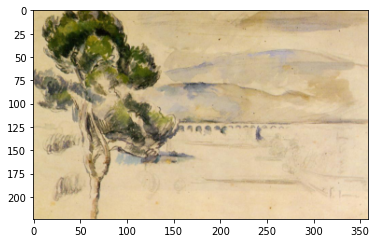

In [ ]:
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import numpy as np

def import_and_predict(path, image_idx):

    ''' path = the path of the training set, validation set or test set
        image_value = index of the image you want to test within the dataset
    '''

    classes = ['Cezanne','Degas','Gauguin','Hassam','Matisse','Monet','Pissarro','Renoir','Sargent','VanGogh']

    data = ImageFolder(test_path, tt.Compose([
              tt.Resize(224), 
            #  tt.RandomCrop(224), # optional to take out or not but visually looks better if it's not included
              tt.ToTensor()]))

    img, label = data[image_idx]
    plt.imshow(img.permute(1,2,0))

    if use_cuda and torch.cuda.is_available:
        img = img.cuda()

    prediction = model(img.unsqueeze(0))
    predictions = prediction.cpu()
    predictions = predictions.detach().numpy()

    string = "Prediction: " + classes[np.argmax(predictions)]
    print(string)
    print("True Label:",classes[label])

import_and_predict(path=test_path, image_idx=47)